In [6]:
import os
import torch
import torch.nn as nn
from PIL import Image
import torchvision.datasets as dsets
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch_directml
import shutil
from transformers import BeitImageProcessor, BeitModel
from scores import score_in_details
torch.manual_seed(240)

In [2]:
dml = torch_directml.device()

In [3]:
class MyDataset(Dataset):
    def __init__(self, ds, processor):
        self.ds = ds
        self.processor = processor
                
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):            
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        pil_image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(pil_image, return_tensors="pt").pixel_values
            
        return {"pixel_values": pixel_values.squeeze(),
                "labels": label,
                "path": image_path}

In [4]:
dataset_path = "../splitted"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}/test/')
image_processor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")
test_ds = MyDataset(ds=test_dataset.imgs, processor=image_processor)

In [5]:
test_loader = DataLoader(test_ds, batch_size=20, drop_last=True, shuffle=False)

In [7]:
class BEiTLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BEiTLSTM, self).__init__()
        self.beit_model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224")
        self.input_size = input_size
        self.hidden_size= hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(self.hidden_size*2, 150),
                                nn.ReLU(),
                                nn.Linear(150, self.num_classes))
        
    def forward(self, x):
        
        outputs = self.beit_model(x).last_hidden_state
        
        h0 = torch.zeros(self.num_layers*2, outputs.size(0), self.hidden_size).to(dml)
        c0 = torch.zeros(self.num_layers*2, outputs.size(0), self.hidden_size).to(dml)
        
        out, _  = self.lstm(outputs, (h0,c0)) #out: tensor of shape (batch size, seq_length, hidden_size)
#         print(out.shape)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out
    

input_size = 768
hidden_size = 300
num_layers = 2
num_classes = 2

base_model = BEiTLSTM(input_size, hidden_size, num_layers, num_classes).to(dml)

In [8]:
model_path = "../trained-models/beitbilstmall.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['beit_model.encoder.layer.0.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.1.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.2.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.3.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.4.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.5.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.6.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.7.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.8.attention.attention.relative_position_bias.relative_position_index', 'beit_model.encoder.layer.9.attention.attention.relative_position_bias.rela

In [9]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['pixel_values'].to(dml)
            labels = batch['labels']
            path = batch["path"]
            
            outputs = softmax(base_model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(probs.numpy())
                
            preds = preds.cpu()
            
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [10]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/943 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.953834  0.990252  0.971702      4924
           1   0.996509  0.983065  0.989741     13936

    accuracy                       0.984942     18860
   macro avg   0.975171  0.986659  0.980722     18860
weighted avg   0.985367  0.984942  0.985032     18860



Accuracy: 98.49416755037116%
Precision: 0.9853670625580597
Recall: 0.9849416755037116
F1-score: 0.985031586023236
MCC-score: 0.9617613846707653
ROC AUC score: 0.8953860228282757




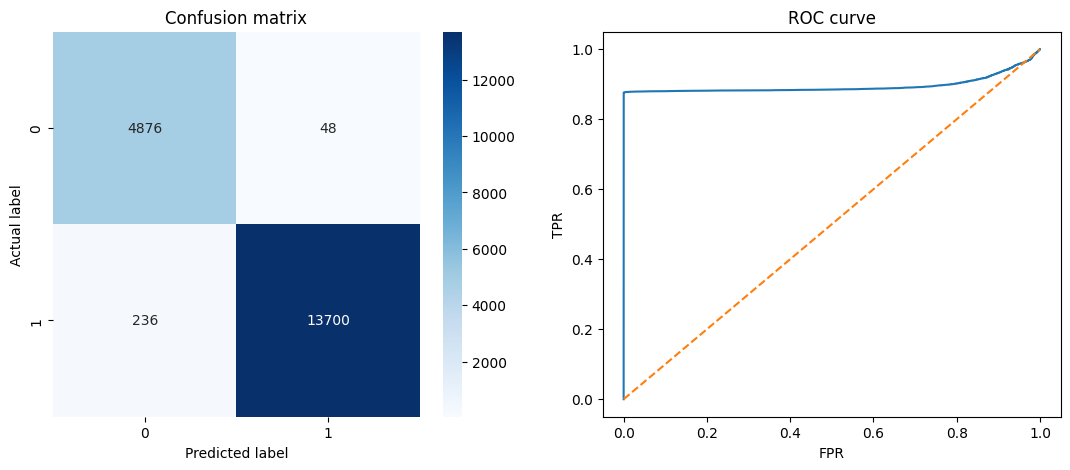

In [11]:
score_in_details(pred=pred, real=real, probas=probas)

In [12]:
dest = "../images/misclassified-new/beitbilstm"
for path, actual, pred in tqdm(misclassified):
    img_name = path.split("\\")[-1].split(".")[0]
    ext = path.split(".")[-1]
    shutil.copy(path, os.path.join(dest, f"{img_name}_{actual}_{pred}.{ext}"))

  0%|          | 0/284 [00:00<?, ?it/s]